# Lab 4: Effects of Strain Rate on the Flexural Properties of Tibias

## Goals

- **Hypotheses** - What effects does the experimental variable (strain rate) have on:
  - Flexural Stiffness
  - Flexural Elastic Modulus
  - Ultimate Flexural Strength
  - Modulus of Toughness
- Present the mean $\pm$ standard deviation and perform statistical tests for:
  - Geometric Dimensions: $h_0,~b_0,~h_i,~b_i$
  - Second Moment of Area: $I$
  - Flexural Stiffness: $k_f$
  - Peak Force: $F_{peak}$
  - Flexural Elastic Modulus: $E_f$
  - Ultimate Flexural Stress, $\sigma_{f, ultimate}$
  - Flexural Strain at Failure, $\varepsilon_{f, failure}$
  - Modulus of Toughness, $u_T$

## Data Analysis

- **Preprocessing:** Convert force-deflection data to flexural stress - flexural strain
  - Calculate the **second moment of area**, $I$ using the equation:
$$I_z = \frac{\pi}{64}\left(b_0h_0^3 - b_ih_i^3\right)$$

- Determine the **flexural stiffness**, $k_f$ from the slope of the linear portion of the force-deflection curve

- Calculate **flexural elastic modulus**, $E_f$ from flexural stiffness using the equation below
$$k_f = \frac{48E_fI}{L^3}$$

- Calculate the **ultimate flexural strength** from the **peak force** using the equation below
$$\sigma_x = \frac{Lh_0}{8I}F$$

- Calculate the **flexural strain at failure**, $varepsilon_{f, failure}$ from the deflection at failure using the equation below
$$\varepsilon_x = \frac{6h_0}{L^2}\delta$$

- Determine the **toughness (energy absorbed per unit volume until failure)** by calculating the area underneath the stress-strain curve at failure.
  - Convert force-deflection data to flexural stress - flexural strain and find the area using numerical integration.

In [1]:
# Google Colab: Run this to mount your Google Drive
# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

# For local only
import os; os.chdir("/home/kabil/sietch/courses/bmes301/lab4")

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
### Data analysis
import pandas as pd
import numpy as np
import tools

### Plotting
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

### Setup
from pathlib import Path
import re

## Define data path
datapath = Path("data")

## Load Data

In [4]:
## Regular expression to pull team information from file name
meta = re.compile(r'G(?P<team>\d{2})_(?P<strain_group>[AB])')

## Load data
raw_data = []
for file in sorted(datapath.glob('*.txt')):

    ## Extract metadata
    m = meta.search(file.name)

    ## Load data
    try:
        _df = tools.load_data(file)
        _df['team'] = int(m.group('team'))
        _df['strain_group'] = m.group('strain_group')
        raw_data.append(_df)
    except AssertionError as e:
        print(f"Error loading {file.name}: {e}")

## Concatenate data
raw_data = (pd.concat(raw_data)
    .sort_values(['team', 'strain_group', 'time'])
    .reset_index(drop=True))
display(raw_data.head())

## Load specimen dimensions
specimen = (pd.read_excel(datapath / 'lab4_specimen_dimensions.xlsx')
    .rename(columns={
        'Group #': 'team',
        'Sample ID': 'strain_group',
        'Strain Rate (s^-1)': 'strain_rate',
        'Outer height (mm)': 'h0',
        'Outer base (mm)': 'b0',
        'Inner height (mm)': 'hi',
        'Inner base (mm)': 'bi',
    })
    .drop(columns=['Notes']))

## Compute second moment of area
specimen['I'] = np.pi / 64 * (specimen['b0']*specimen['h0']**4 - specimen['bi']*specimen['hi']**4)
display(specimen.head())

## Fixed Span Length
L = 40  # mm

,deflect,force,time,team,strain_group
0,0.000000,5.495511,0.00,1,A
1,0.000305,5.529965,0.01,1,A
2,0.000712,5.483844,0.02,1,A
3,0.000966,5.464621,0.03,1,A
4,0.001322,5.568797,0.04,1,A


,team,strain_group,strain_rate,h0,b0,hi,bi,I
0,1,A,0.0016,6.70,7.50,4.65,4.80,631.714628
1,1,B,0.4000,7.57,9.73,5.57,6.53,1259.899441
2,2,A,0.0016,7.10,8.30,3.90,5.10,977.420176
3,2,B,0.4000,6.70,7.10,4.10,4.50,639.888597
4,3,A,0.0016,8.84,12.00,7.14,9.10,2436.238790


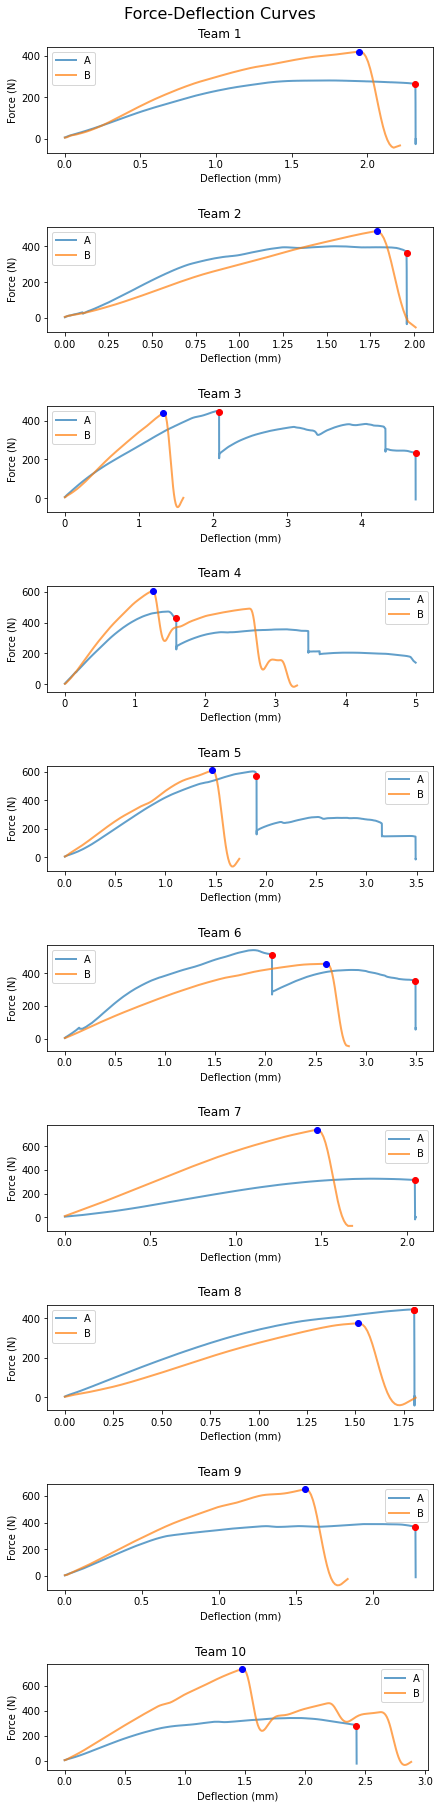

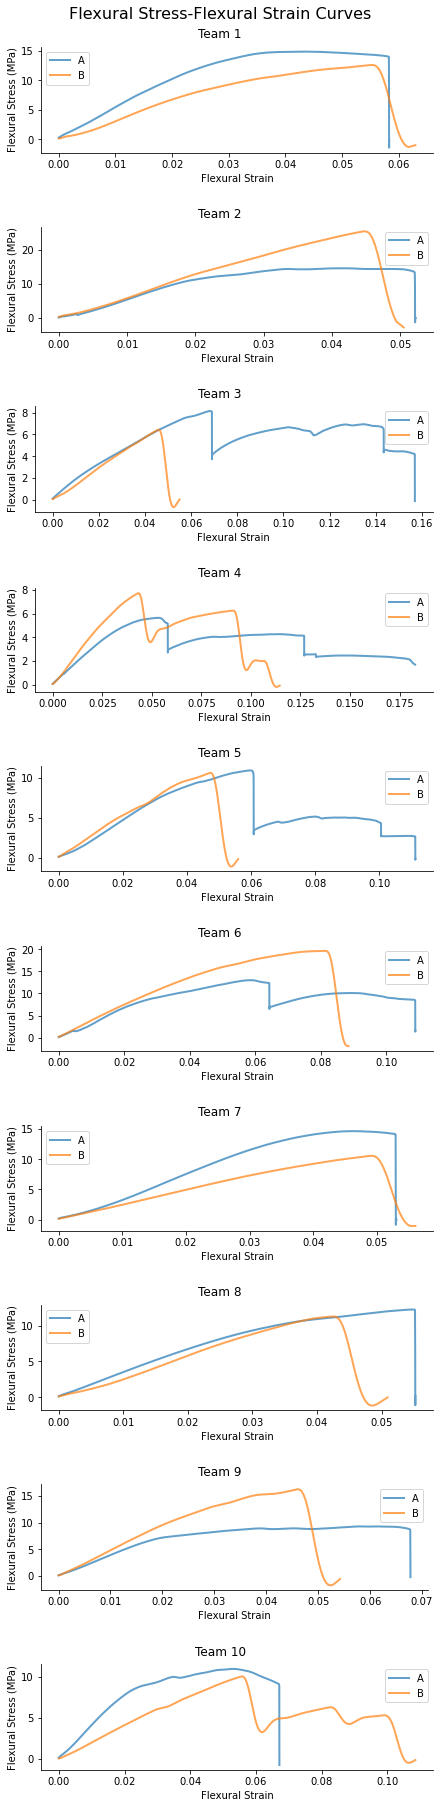

In [19]:
# Force-Deflection Figures
FD_fig = plt.figure(constrained_layout=True, figsize=(6, 25))
FD_fig.suptitle("Force-Deflection Curves", fontsize=16)
FD_subfigs = FD_fig.subfigures(10, 1, wspace=0.1, hspace=0.1)

## Flexural Stress-Flexural Strain Figures
SS_fig = plt.figure(constrained_layout=True, figsize=(6, 25))
SS_fig.suptitle("Flexural Stress-Flexural Strain Curves", fontsize=16)
SS_subfigs = SS_fig.subfigures(10, 1, wspace=0.1, hspace=0.1)

for team, FD, SS in zip(raw_data['team'].unique(), FD_subfigs, SS_subfigs):

    ## FD: Create axes
    FD.suptitle(f"Team {team}")
    FD_ax = FD.add_subplot(111)
    FD_ax.set_xlabel("Deflection (mm)")
    FD_ax.set_ylabel("Force (N)")

    ## SS: Create axes
    SS.suptitle(f"Team {team}")
    SS_ax = SS.add_subplot(111)
    SS_ax.set_xlabel("Flexural Strain")
    SS_ax.set_ylabel("Flexural Stress (MPa)")

    for strain_group, color in zip(raw_data['strain_group'].unique(), ['red', 'blue']):

        ## Subset data
        _df = (raw_data.query("team == @team & strain_group == @strain_group")
            .reset_index(drop=True))

        ## Locate yield point
        force = _df['force'].values
        deflect = _df['deflect'].values
        if strain_group == 'A':
            I = np.where(abs(np.diff(force)) > 100)[0] - 1
        else:
            I = np.argmax(np.diff(force) < 0)

        
        ## Plot Force-Deflection Curve
        sns.lineplot(data=_df, x='deflect', y='force', ax=FD_ax, 
                    label=f"{strain_group}", linewidth=2, alpha=0.7)
        sns.despine()

        FD_ax.plot(_df.loc[I, 'deflect'], _df.loc[I, 'force'], 'o', color=color)
        
        ## Compute flexural stress and flexural strain
        h0 = specimen.query("team == @team & strain_group == @strain_group")['h0'].values[0]
        I = specimen.query("team == @team & strain_group == @strain_group")['I'].values[0]
        _df['flex_stress'] = (L * h0) / (8 * I) * _df['force']
        _df['flex_strain'] = (6 * h0) / (L**2) * _df['deflect']

        ## Plot Flexural Stress-Flexural Strain Curve
        sns.lineplot(data=_df, x='flex_strain', y='flex_stress', ax=SS_ax,
                     label=f"{strain_group}", linewidth=2, alpha=0.7)
        sns.despine()

In [41]:
team

3

In [42]:
strain_group

'A'

In [46]:
specimen

,team,strain_group,strain_rate,h0,b0,hi,bi,I
0,1,A,0.0016,6.700000,7.500000,4.650000,4.800000,631.714628
1,1,B,0.4000,7.570000,9.730000,5.570000,6.530000,1259.899441
2,2,A,0.0016,7.100000,8.300000,3.900000,5.100000,977.420176
3,2,B,0.4000,6.700000,7.100000,4.100000,4.500000,639.888597
4,3,B,0.4000,9.170000,9.530000,5.000000,5.600000,3136.001000
5,4,A,0.0016,9.750000,10.900000,6.758000,7.470000,4070.377571
6,4,B,0.4000,9.230000,11.670000,6.100000,7.970000,3615.960542
7,5,A,0.0016,8.500000,10.000000,5.100000,6.400000,2349.857130
8,5,B,0.4000,8.600000,10.300000,5.500000,6.500000,2473.706462
9,6,A,0.0016,8.300000,10.200000,6.330000,8.230000,1727.585587


In [45]:
specimen.query("team == @team")

,team,strain_group,strain_rate,h0,b0,hi,bi,I
4,3,B,0.4,9.17,9.53,5.0,5.6,3136.001


In [22]:
team

10

In [23]:
strain_group

'B'